In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/workshops/project'
FOLDERNAME = 'ACM_Error404/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/ACM_Error404/project


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict, namedtuple
import os

from PIL import Image

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(229)

import pandas as pd

import util
import webmercator
from tqdm import tqdm

**Part 1:** The first function you should write is `csv_to_data()`. This should take in a filename and returns a dictionary `data` from zipcode to average income.

In [4]:
def csv_to_data(filename):
    
    """Takes in a `filename` and returns a dictionary `data` from zipcode to average income.
    For a given row, the average income is computed as 
    
    row['A02650'] / row['N1']"""
    pdData = pd.read_csv(filename)
    data = {}
    for idx, row in pdData.iterrows():
      if (idx != 0) :
        data[row['ZIPCODE']] = row['A02650'] / row['N1']

    return data

In [5]:
data = csv_to_data('16zpallnoagi.csv')
print(data)

{35004: 55.712092130518236, 35005: 39.25483870967742, 35006: 47.848333333333336, 35007: 58.449078726968175, 35010: 48.58647281921618, 35014: 46.43703703703704, 35016: 51.47096774193548, 35019: 43.812359550561794, 35020: 27.79447513812155, 35022: 56.300714285714285, 35023: 46.70457711442786, 35031: 42.42622377622378, 35033: 59.35217391304348, 35034: 37.601438848920864, 35035: 66.1842105263158, 35040: 52.96627140974967, 35042: 47.02818181818182, 35043: 83.24871794871795, 35044: 41.89248366013072, 35045: 46.83109090909091, 35046: 53.37872340425532, 35049: 49.151612903225804, 35051: 63.374468085106386, 35053: 63.894285714285715, 35054: 70.18516483516484, 35055: 52.270943396226414, 35057: 53.896030245746694, 35058: 51.113507109004736, 35060: 27.78125, 35061: 35.0421875, 35062: 53.32515527950311, 35063: 43.52, 35064: 34.34348837209302, 35068: 48.13058510638298, 35071: 62.06350267379679, 35072: 39.674725274725276, 35073: 39.34193548387097, 35077: 42.84548944337812, 35078: 49.733333333333334, 

**Part 2:** you should write the `load_zip_latlon_info` function. This function should:

- Take in a filename representing a path to a latitude/longitude data file with the following columns of interest:
    - `zip`: the zipcode
    - `state`: the state of the zipcode
    - `latitude`, `longitude`: the latitude and longitude of the zipcode
- Keep only zipcodes that are in our `data` dictionary.
- Convert the latitude and longitude to `x, y` values. (The `webmercator.xy(lat, lon, z)` function may be helpful here.)
- Create a dictionary from zipcode to `(x, y)` tuples.

In [6]:
def load_zip_latlon_info(filename):
    """Takes in a `filename` and returns a dictionary from zipcode to (x, y)."""
    df = pd.read_csv(filename, sep=';')                     # the datafile is separated by semicolons for some reason
    df = df[df['state'] == 'CA']                            # will make your code more efficient to only work on CA
    zip_to_latlon = {}
    for idx, row in df.iterrows():                          # loop through the rows of the dataframe
        x, y = webmercator.xy(row['latitude'], row['longitude'], 14)       # fill this in

        if (2794 <= x <= 2839) and (6528 <= y <= 6572):     # only zip codes in the data set
             zip_to_latlon[row['zip']] = (x, y)             
    return zip_to_latlon

In [7]:
zip_to_latlon = load_zip_latlon_info('ziplatlon.csv')

data = dict([kv for kv in data.items() if kv[0] in zip_to_latlon])        # only keep zipcodes with labels 
print(data)

{90001: 28.594139363174897, 90002: 28.314328808446454, 90003: 26.77940637596189, 90004: 71.75785688601222, 90005: 50.961703470031544, 90006: 29.795523685354194, 90007: 30.304516640253567, 90008: 52.619015957446805, 90010: 219.34897119341565, 90011: 26.776114732724903, 90012: 58.78833474218089, 90013: 75.38333333333334, 90014: 81.7919770773639, 90015: 72.19791907514451, 90016: 42.65792764627066, 90017: 70.87924921793535, 90018: 37.746850928862706, 90019: 53.70663474692203, 90020: 66.69717764250139, 90021: 105.01159420289855, 90022: 33.93567821067821, 90023: 31.06272677295217, 90024: 364.07481824190353, 90025: 198.24428404213813, 90026: 54.093314411857456, 90027: 89.49915682967959, 90028: 49.16011787819254, 90029: 37.84497354497355, 90031: 37.31180722891566, 90032: 42.16275201612903, 90033: 30.596745230078565, 90034: 72.92488614183475, 90035: 106.22087205146534, 90036: 111.64958634953464, 90037: 26.997560975609755, 90038: 45.956048084147255, 90039: 81.1437917222964, 90040: 55.55825932504

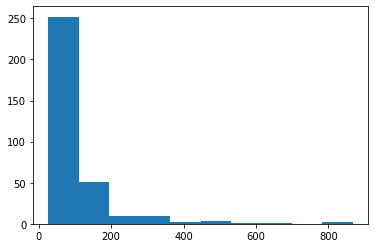

867.4697674418604


In [8]:
plt.hist(list(d for d in data.values()))
plt.show()
print(max(list(d for d in data.values())))

**Part 3:** Write a function `euclidean_distance` that takes in two (x, y) tuples and returns the **squared** Euclidean distance between the two points.

In [9]:
def euclidean_distance(pt1, pt2):
    return ((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

**Part 4**: Write the dataset. The comments should be helpful in walking you through it.

For more understanding of how a dataset works, please consult the project handout.

Our implementation of the dataset takes about 6 minutes to finish running.  There are definitely more efficient ways to do it.

In [10]:
class ImageDataset(Dataset):
    def __init__(self, main_dir, transform, data, zip_to_latlon):
        self.main_dir = main_dir
        self.transform = transform
        self.data = data
        self.zip_to_latlon = zip_to_latlon

        # Remove zip codes without labels
        zips = set(zip_to_latlon.keys()).intersection(set(self.data.keys()))
        self.zip_to_latlon = {k: zip_to_latlon[k] for k in zips}
        
        self.latlons = []
        self.total_imgs = []
        oceanic = 0

        # This loops through all the images in the directory.
        for filename in tqdm(sorted(os.listdir(main_dir))):             # tqdm lets you get a nice progress bar
            # Step 1: if the filename is not a .jpg, continue. 
            if filename.endswith('.jpg') :
              # Step 2: extract the x and y values out of the filename.
              # Remember that a filename is of the form: 14_2817_6565.jpg 
              # where x=2817, y=6565.
              s = filename
              x = int(s[3:7])
              y = int(s[8:12])
              # Step 3: check if the tile is oceanic (i.e. has elevation 0).
              # The util.getElevation function takes in a **latitude** and **longitude** and returns an elevation.
              # To get a latitude and longitude from a x and y, use `webmercator.latlon(x, y, z=14)`.
              # If it is, ignore it.
              lat, lon = webmercator.latlon(x, y, z=14)
              elevation = util.getElevation(lat, lon)
              if elevation != oceanic:
                # Step 4: Append (x, y) to the self.latlons list.
                self.latlons.append((x, y))
                image = Image.open(os.path.join(main_dir,filename)).convert("RGB")
                self.total_imgs.append(image)
            
        self.zipcodes = []                                              # a list of zipcodes 
        self.tile_to_zipcode = {}
        # get the list of zip codes we need
        for zipcode, (zipcode_x, zipcode_y) in self.zip_to_latlon.items():   # loops through zipcodes and their x, y coordinates
            for x, y in self.latlons:                                   
                if self.in_tile((zipcode_x, zipcode_y), (x, y)):        # check if this zipcode is in the tile
                    self.zipcodes.append(zipcode)
                    self.tile_to_zipcode[(x, y)] = zipcode
        
        for idx, (x, y) in enumerate(self.latlons):
            if (x, y) not in self.tile_to_zipcode:                      # if this tile isn't already assigned
                # find the closest zipcode
                # you can use the `min(self.zipcodes, key=FUNCTION)` here
                best_zipcode = min(self.zipcodes, key=lambda z: euclidean_distance((x, y), self.zip_to_latlon[z]) )           # used euclid distance to compare (x, y) 
                self.tile_to_zipcode[(x, y)] = best_zipcode

        print(len(self.tile_to_zipcode), "entries.")
                
    def __len__(self):
        """Return the length of the dataset—how many images there are, total."""
        return len(self.total_imgs)
    
    def coordinates(self, zipcode):
        """Returns the coordinates of the given zipcode."""
        return self.zip_to_latlon[zipcode]      # check with scott
    
    def in_tile(self, coord, square):
        """checks whether a given coordinate is in a tile"""
        lat, lon = coord
        llat, llon = square
        ulat, ulon = llat + 1, llon + 1
        return (lat >= llat and lon >= llon and lat <= ulat and lon <= ulon)
  
    def get_image(self, idx):
        """Returns the image at this index."""
        return self.transform(self.total_imgs[idx])

    def get_label(self, idx):
        """Given an index, return the ground truth label for that index."""
        return self.data[self.tile_to_zipcode[self.latlons[idx]]]                       # ask scott
    
    def __getitem__(self, idx):
        """Return the image and label at a given index"""
        tensor_image = self.get_image(idx)
        label = self.get_label(idx)

        return tensor_image, label
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

In [11]:
dset = ImageDataset('imagery', ToTensor(), data, zip_to_latlon)

100%|██████████| 1980/1980 [00:04<00:00, 491.04it/s]


1457 entries.


In [12]:
dset[0][0]

tensor([[[0.6353, 0.6157, 0.5882,  ..., 0.6314, 0.6471, 0.6196],
         [0.6549, 0.6157, 0.5882,  ..., 0.6078, 0.6235, 0.6039],
         [0.5843, 0.5686, 0.5804,  ..., 0.5882, 0.6078, 0.5922],
         ...,
         [0.1765, 0.2235, 0.2196,  ..., 0.5608, 0.4784, 0.5882],
         [0.2667, 0.1529, 0.1373,  ..., 0.5686, 0.5255, 0.5647],
         [0.3922, 0.0902, 0.0078,  ..., 0.5882, 0.4824, 0.6078]],

        [[0.5686, 0.5490, 0.5216,  ..., 0.5255, 0.5294, 0.5020],
         [0.5882, 0.5490, 0.5216,  ..., 0.5020, 0.5176, 0.4980],
         [0.5176, 0.5020, 0.5137,  ..., 0.4824, 0.5020, 0.4863],
         ...,
         [0.2039, 0.2510, 0.2392,  ..., 0.5451, 0.4745, 0.5843],
         [0.2902, 0.1765, 0.1647,  ..., 0.5529, 0.5216, 0.5608],
         [0.4275, 0.1137, 0.0353,  ..., 0.5725, 0.4784, 0.6039]],

        [[0.4510, 0.4314, 0.4039,  ..., 0.4118, 0.4196, 0.3922],
         [0.4706, 0.4314, 0.4039,  ..., 0.3882, 0.4039, 0.3843],
         [0.4000, 0.3843, 0.4039,  ..., 0.3686, 0.3882, 0.

This code block creates train and validation dataloaders.

In [13]:
validation_split = 0.10
dataset_size = len(dset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [14]:
train_dataloader = DataLoader(dset, batch_size=32, sampler=train_sampler)
valid_dataloader = DataLoader(dset, batch_size=32, sampler=valid_sampler)

In [15]:
batch = next(iter(train_dataloader))
img = batch[0]
print(img[0]==img[1])

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False,  True],
         [

**Step 5**: Create the model.  Workshop 3 may be useful for this.
We suggest a series of convolutional layers interspersed with `torch.nn.MaxPool2d` layers, followed by a series of linear layers.
Each convolutional and linear layer should be followed by an activation function.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
      """ Questions:
      * for conv2d: how to figure out i/o channels for convd2d
      * figure out ourselves, more will be more fitting
      * in, out, kernel size
      * for fc: do we need to specify "num_channels * height * width"? <- seen in workshop 3 
      """
      """ Helpful notes on parameters:
      * Convolutional layers may be created with nn.Conv2d(in_channels, out_channels, kernel_size)
      * Pooling layers are available as nn.MaxPool2d(kernel_size, stride)
      """
      super(Model, self).__init__()
      self.conv1 = nn.Conv2d(3, 8, 10) 
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(8, 20, 10)
      self.conv3 = nn.Conv2d(20, 50, 10)
      #self.conv4 = nn.Conv2d(50, 70, 10)
      self.fc1 = nn.Linear(28800, 5)
      self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
      # print(x.shape)
      x = self.pool(F.relu(self.conv1(x)))
      # print(x.shape)
      x = self.pool(F.relu(self.conv2(x)))
      # print(x.shape)
      x = self.pool(F.relu(self.conv3(x)))
      # print(x.shape)
      #x = self.pool(F.relu(self.conv4(x)))
      print(x.shape)
      x = x.view(x.shape[0], -1)
      # x.shape
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return x.squeeze()

In [17]:
model = Model()
x = torch.ones((4,3,256,256))
x[0] = 0
model(x)

torch.Size([4, 50, 24, 24])


tensor([0.4320, 0.4311, 0.4311, 0.4311], grad_fn=<SqueezeBackward0>)

**Step 6**: Train the model. Use `torch.nn.MSELoss(reduction='sum')` here, or one of the other losses specified in the project spec, since we're trying to output a real value (not categories). 

In [18]:
# train loop
model = Model()
criterion = torch.nn.MSELoss(reduction='sum')    # or do we try BCEWithLogitsLoss
# CUDA_LAUNCH_BLOCKING=1
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 

writer = SummaryWriter()

num_epochs = 50
for epoch_num in range(num_epochs):
  avg_train_loss = 0
  avg_train_l1 = 0
  model.train()
  for i, (img_batch, label) in enumerate(train_dataloader):
      img_batch = img_batch.cuda().to(dtype=torch.float32)
      label = label.cuda().to(dtype=torch.float32)

      optimizer.zero_grad()

      pred = model(img_batch).squeeze()            
      loss = criterion(pred, label)            

      # print(img_batch)
      print("label: ",label)
      print("pred: ",pred)   

      loss.backward()
      loss = loss.detach()
    
      avg_train_loss += loss.detach()
      avg_train_l1 += torch.abs(pred - label).sum()
      torch.nn.utils.clip_grad_norm(model.parameters(), 10)     # put this back in
      optimizer.step()

      # make model deeper
      # look at loss-- if constant values/close range, then underfitting
      # if val is low but train is high, over
      # more conv layers with smaller kernel sizes (3-5)
      # batch norming
      # changing loss function isn't as high priority
      # hyperparameters:
      # regularization (like l2 or clip_grad_norm)
      # number of epochs
      # loss function, optimizer

  avg_train_loss /= len(train_indices)
  avg_train_l1 /= len(train_indices)

  with torch.no_grad():
      model.eval()
      avg_val_loss = 0
      avg_val_l1 = 0
      for i, (img_batch, label) in enumerate(valid_dataloader):
        img_batch = img_batch.cuda().to(dtype=torch.float32)
        label = label.cuda().to(dtype=torch.float32)

        # just added this - isabel
        pred = model(img_batch).squeeze()            
        loss = criterion(pred, label)              

        print("label: ",label)
        print("pred: ",pred)

        # Step 1: feed your predictions into the model, outputting a variable `pred`
        # Step 2: calculate the loss w.r.t the predictions and the labels
        avg_val_loss += loss
        avg_val_l1 += torch.abs(pred - label).sum()
      avg_val_loss /= len(val_indices)
      avg_val_l1 /= len(val_indices)
        
  print(epoch_num, float(avg_train_loss), float(avg_val_loss), float(avg_train_l1), float(avg_val_l1))

torch.Size([32, 50, 24, 24])
label:  tensor([164.1673, 124.7456,  55.5583,  70.9342, 304.0040,  34.9108,  46.0140,
        120.3665,  79.9095,  79.1481, 111.7105, 125.5694, 416.9147,  58.2157,
         92.1811, 106.3522,  92.2328, 132.5861,  62.9751,  43.4978,  48.3699,
        125.5694, 176.9000,  58.5149,  46.9732,  89.8405,  96.5824,  72.1329,
        107.1490, 109.7756,  50.8559,  52.4349], device='cuda:0')
pred:  tensor([0.3144, 0.3141, 0.3134, 0.3144, 0.3149, 0.3138, 0.3141, 0.3128, 0.3113,
        0.3125, 0.3143, 0.3139, 0.3150, 0.3136, 0.3174, 0.3152, 0.3132, 0.3115,
        0.3131, 0.3140, 0.3143, 0.3148, 0.3146, 0.3189, 0.3109, 0.3172, 0.3152,
        0.3161, 0.3155, 0.3162, 0.3162, 0.3147], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
torch.Size([32, 50, 24, 24])
label:  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
         90.0287, 119.3381, 126.5246,  77.9488,  84.7169,  82.7558,  78.6125,
        210.1453,  76.2167,  97.5170,  87.9550,  97.0788, 105.7996,  77.3887,
         85.9352, 166.9130,  89.6531,  76.6759], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
torch.Size([32, 50, 24, 24])
label:  tensor([111.7105,  92.2328, 164.1673,  71.7699,  91.2913, 109.7467,  37.6322,
         34.9108,  81.2114,  97.0172, 124.7456,  53.2414, 119.5632,  53.8938,
         75.8565, 109.7756, 125.5694, 289.3062,  71.3308, 146.7128, 181.2650,
        512.4812,  50.9595,  35.4717, 139.5305,  85.4407,  59.2301, 106.2209,
        110.4544,  75.8565, 117.1484,  28.5941], device='cuda:0')
pred:  tensor([ 86.5544, 102.9931, 121.2779,  78.8704,  78.5015,  79.0018,  84.1582,
         81.8610,  82.7980, 183.8009, 133.3483, 122.4436, 180.9684,  73.5931,
        148.2181,  84.4972, 184.5018, 127.8516,  92.5877,  79.3498, 241.3675,
         91.9533,  80.1392,  84.9406

In [ ]:
print(pred)

In [20]:
# val_dset = dset[val_indices]
accuracy = 0;
num = 0;
for i in val_indices:
    display(dset.total_imgs[i])
    print("Actual:", dset[i][1])
    print("Predicted:", model(dset[i][0].cuda().unsqueeze(0)).item())
    accuracy += model(dset[i][0].cuda().unsqueeze(0)).item()/dset[i][1]
    # print("Accuracy: ",accuracy)
    num +=1

accuracy /= num
print("Accuracy: ",accuracy)

Output hidden; open in https://colab.research.google.com to view.

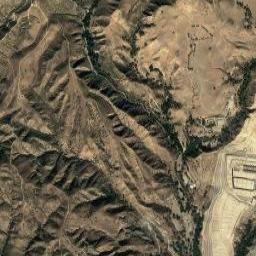

torch.Size([1, 50, 24, 24])


tensor(117.0072, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [34]:
from PIL import Image

transform = torchvision.transforms.ToTensor()

def predict(path):
  image = Image.open(path).convert("RGB")
  # dset = ImageDataset('imagery', ToTensor(), image, {})
  # image = Image.open(path).convert("RGB")
  # image = dset[0][0]
  display(image)
  image = transform(image)
  image = image.cuda().unsqueeze(0)
  # print("Predicted Distribution Income: ", model(image))
  return model(image)

predict("imagery/14_2794_6528.jpg")

In [35]:
# save here
torch.save(model, "Error404.pth")
# if its too large for gradescope, give a google drive link instead (submit, email, or slack)